In [1]:
!pip install -r requirements.txt --user

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Imports

In [1]:
import pandas as pd
from LPA import Corpus, sockpuppet_distance , PCA
import altair as alt
alt.data_transformers.disable_max_rows()
import os
from typing import List
from visualize import plot_pca
import re
from collections import Counter
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import zipfile
from bs4 import BeautifulSoup
import shutil
import html2text
import re
import ast
import scipy.stats as stats
from sklearn.metrics import f1_score, precision_score, recall_score

# Global Variables 

## Functions

In [2]:
def read_array_of_dicts_file(file_path):
    with open(file_path, "r") as file:
        # Read the file contents as a string
        file_contents = file.read().rstrip()
        # Convert the string to a Python object (list of dictionaries)
        array_of_dicts = ast.literal_eval(file_contents)
    return array_of_dicts

In [3]:
def make_dirs(experimentpath):# Set up directories for the experiment
    os.makedirs(experimentpath , exist_ok=True)
    os.makedirs(experimentpath+"/Images" , exist_ok=True)
    #Signatures Folders
    os.makedirs(experimentpath+"/Signatures" , exist_ok=True)
    os.makedirs(experimentpath+"/Signatures/Divided_by_authors" , exist_ok=True)
    os.makedirs(experimentpath+"/Signatures/UnDivided_authors" , exist_ok=True)
    os.makedirs(experimentpath+"/Signatures/Prompts" , exist_ok=True)
    #Data Folders
    os.makedirs(experimentpath+"/Data" , exist_ok=True)
    os.makedirs(experimentpath+"/Data/FanFictionTXT" , exist_ok=True)
    os.makedirs(experimentpath+"/Data/FanFictionCSV" , exist_ok=True)
    os.makedirs(experimentpath+"/Data/FanFictionNormalSizesCSV" , exist_ok=True)
    os.makedirs(experimentpath+"/Data/Divided_by_authors" , exist_ok=True)
    os.makedirs(experimentpath+"/Data/authors_with_2Stories_OrLess" , exist_ok=True)
    os.makedirs(experimentpath+"/Data/2Stories_OrLess_Undivided" , exist_ok=True)
    os.makedirs(experimentpath+"/Data/Prompts" , exist_ok=True)
    #Results Folders
    os.makedirs(experimentpath+"/Results" , exist_ok=True)
    os.makedirs(experimentpath+"/Results/Author_Results" , exist_ok=True)
    os.makedirs(experimentpath+"/Results/Prompts" , exist_ok=True)
    os.makedirs(experimentpath+"/Results/Distances" , exist_ok=True)

In [4]:
# write each dictionary as a row in the CSV file
def prompts_to_csv(my_list_of_dicts , out_path):
    for my_dict in my_list_of_dicts:
        if len(my_dict["prompt"]) > 90:
            my_dict["prompt"] =   my_dict["prompt"][:90]+".csv"
        with open(out_path+my_dict["prompt"]+".csv", "w", newline="", encoding="utf8") as output_file:
                # write the story info to a csv file
                writer = csv.DictWriter(output_file, fieldnames=["id", "prompt", "FullStory"])
                writer.writeheader()
                writer.writerow(my_dict)


In [5]:
def run_LPA_Undivided(experimentpath):
    res_folder = experimentpath+"/Results/FanFiction"
    author_name = folder_path.rsplit(type1, 1)[-1]
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    # Run LPA and DVR    
    freq = read_csv_folder(folder_path + "/word_freq")
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    corpus = Corpus(freq=freq)
    dvr = corpus.create_dvr()
    #Export to csv
    dvr.to_csv(experimentpath +"/"+author_name+"-dvr.csv",mode='w',header=True, index=True)
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    epsilon
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
    ## Export signitures
    if not os.path.exists(experimentpath + "/Signatures"):
        os.makedirs(experimentpath + "/Signatures/")
    write_dataframes_to_csv(signatures , outputFolder = res_folder + "/Signatures/" )
    
    

In [14]:
def run_LPA_for_each_author(experimentpath):
    nonprompts = experimentpath+"/Data/authors_with_2Stories_OrLess"
    for folder_name in os.listdir(nonprompts):
        folder_path = os.path.join(nonprompts, folder_name)
        LPA_Wrapper_Author(folder_path , experimentpath)

In [15]:
def LPA_Wrapper_Author(folder_path , experimentpath):
    # Set Up The Folder
    res_folder = folder_path + "/LPA_Results"
    author_name = folder_path.rsplit(type1, 1)[-1]
    res_folder = experimentpath+"/Results/Author_Results/"+author_name
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    # Run LPA and DVR    
    freq = read_csv_folder(folder_path + "/word_freq")
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    corpus = Corpus(freq=freq)
    dvr = corpus.create_dvr()
    #Export to csv
    dvr.to_csv(res_folder +"/"+author_name+"-dvr.csv",mode='w',header=True, index=True)
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    epsilon
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
    ## Export signitures
    if not os.path.exists(experimentpath + "/Signatures/Author_Results/"+author_name):
        os.makedirs(experimentpath + "/Signatures/Author_Results/"+author_name)
    write_dataframes_to_csv(signatures , outputFolder = experimentpath + "/Signatures/Author_Results/"+author_name )

In [16]:
def wordfreqAll(experimentpath):
    nonprompts = experimentpath+"/Data/authors_with_2Stories_OrLess"
    nonprompts_undivided = experimentpath+"/Data/2Stories_OrLess_Undivided"
    for folder_name in os.listdir(nonprompts):
        folder_path = os.path.join(nonprompts, folder_name)
        word_freq_full_folder(folder_path)
    word_freq_full_folder(folder_path = nonprompts_undivided)


In [17]:
def preprocess_Data(experimentpath , min_length , max_length):
    txt_to_csv(folder_path=experimentpath+"/Data/FanFictionTXT" , out_path = experimentpath+"/Data/FanFictionCSV")
    move_only_normal_sizes(experimentpath+"/Data/FanFictionCSV",
                           experimentpath+"/Data/FanFictionNormalSizesCSV" , min_length=min_length-50 , max_length = max_length+50)
    copy_csv_to_folders(experimentpath+"/Data/FanFictionNormalSizesCSV" ,experimentpath+"/Data/Divided_by_authors")
    copy_folders_with_up_to_files(experimentpath+"/Data/Divided_by_authors",
                                     experimentpath+"/Data/authors_with_2Stories_OrLess")
    copy_all_files(experimentpath+"/Data/authors_with_2Stories_OrLess", experimentpath+"/Data/2Stories_OrLess_Undivided")

In [18]:
def unzipfromDataset(key_word , experimentpath, dataset_folder = "Dataset/" ):
    for file_name in os.listdir(dataset_folder):
        if file_name.endswith(".zip"):
            unzipFile(os.path.join(dataset_folder, file_name) , key_word , experimentpath+"/Data/FanFictionTXT")
            

## Directory Functions

In [19]:
def unzipFile(zip_path , keyword , dest):
    # create a directory for the harry potter files
#     os.makedirs(keyword, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zip_file:
    # loop over all files in the zip file
        for member in zip_file.namelist():
            filename = os.path.basename(member)
            # skip directories
            if not filename:
                continue
            # check if the file name contains "harry potter" (case-insensitive)
            if keyword in member.lower():
                source = zip_file.open(member)
                target = open(os.path.join(dest, filename), "wb")
                with source, target:
                    shutil.copyfileobj(source, target)
                # extract the file to the harry potter directory
#                 zip_file.extract(file_name, dest)
                
def remove_extra_white_space(source):
    """
    removes extra white spaces (more than 1 in a row).
    @param source:The original text
    @type source:str
    @return:A string without extra whitespaces
    @rtype:str
    """
    return re.sub(' +', ' ', source).strip()


def clean_with_html2text(handler, raw_html):
    """
    Use HTML2Text to clean data
    @param handler: preference of the way of cleaning
    @type handler:HTML2Text
    @param raw_html:A string of html code
    @type raw_html:str
    @return:clean document
    @rtype:str
    """
    return handler.handle(raw_html)


def create_handler(ignore_links=True, ignore_images=True, ignore_emphasis=True, skip_internal_links=True,
                   ignore_anchors=False):
    """
    Create a Handler for HTML2Text
    @param ignore_links:
    @type ignore_links:
    @param ignore_images:
    @type ignore_images:
    @param ignore_emphasis:
    @type ignore_emphasis:
    @param skip_internal_links:
    @type skip_internal_links:
    @param ignore_anchors:
    @type ignore_anchors:
    @return:
    @rtype:
    """
    handler = html2text.HTML2Text()
    handler.ignore_links = ignore_links
    handler.ignore_images = ignore_images
    handler.ignore_emphasis = ignore_emphasis
    handler.skip_internal_links = skip_internal_links
    handler.ignore_anchors = ignore_anchors
    return handler

def clean_html_beautiful_soup(raw_html):
    """
    Clean HTML using BeautifulSoup # returns String
    @param raw_html:
    @type raw_html:
    @return:only displayed text from html code
    @rtype:str
    """
    gfg = BeautifulSoup(raw_html)
    res = gfg.get_text()
    return res                


def txt_to_csv(folder_path="harry potter\H" , out_path = "harry potter\csv"):
    meta_keys = ["Category:", "Genre:", "Language:", "Status:", "Published:", "Updated:", "Packaged:", "Rating:", "Chapters:", 
                 "Words:","Publisher:", "Story URL:", "Author URL:", "Summary:"]
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            # set the input and output file paths
            input_file_path = os.path.join(folder_path, file_name)
            output_file_path = os.path.join(out_path, file_name.replace(".txt", ".csv"))

            # open the input and output files
            with open(input_file_path, "r" , encoding="utf8") as input_file , open(output_file_path, "w", newline="", encoding="utf8") as output_file:
                story_info = {}
                fullstory = ""
                for idx , line in enumerate(input_file.readlines()):
                    if  line.strip() == "End file.":
                        continue
                    if line.strip():
#                         print (idx , line)
                        if any (s in line for s in meta_keys):
                            key, value = line.split(":", 1)
                            if key not  in story_info:
                                story_info[key.strip()] = value.strip()
                        else:
                            fullstory = fullstory + " "+ line
                
                story_info["FullStory"] =  clean_html_beautiful_soup(remove_extra_white_space(fullstory))
                # write the story info to a csv file
                writer = csv.DictWriter(output_file, fieldnames=story_info.keys())
                writer.writeheader()
                writer.writerow(story_info)
                

def move_only_normal_sizes(input_folder, output_folder , max_length=600 , min_length=100 , field ="FullStory"):
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".csv"):
            input_file_path = os.path.join(input_folder, file_name)
            output_file_path = os.path.join(output_folder, file_name)
            df = pd.read_csv(input_file_path , low_memory = False)
            if len(df.loc[0, field].split()) >= min_length and  len(df.loc[0, field].split()) <= max_length:
                df[field] = df[field].str.rstrip('End file.').str.strip() 
                df.to_csv(output_file_path,mode='w',header=True, index=True)

                
def copy_folders_with_multiple_files(source_folder, dest_folder , min_num_of_files= 2):
    """
    Copies subfolders from a source folder to a destination folder only if the subfolder
    contains more than one file.
    
    Args:
    - source_folder (str): Path to the source folder.
    - dest_folder (str): Path to the destination folder.
    """
    
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Iterate over all subfolders in the source folder
    for folder_name in os.listdir(source_folder):
        folder_path = os.path.join(source_folder, folder_name)
        # Check if the current item is a directory
        if os.path.isdir(folder_path):
            # Check if the current directory contains more than one file
            if len(os.listdir(folder_path)) >= min_num_of_files:
                # Copy the entire directory to the destination folder
                shutil.copytree(folder_path, os.path.join(dest_folder, folder_name))                

def copy_folders_with_up_to_files(source_folder, dest_folder , max_num_of_files= 2):
    """
    Copies subfolders from a source folder to a destination folder only if the subfolder
    contains more than one file.
    
    Args:
    - source_folder (str): Path to the source folder.
    - dest_folder (str): Path to the destination folder.
    """
    
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Iterate over all subfolders in the source folder
    for folder_name in os.listdir(source_folder):
        folder_path = os.path.join(source_folder, folder_name)
        # Check if the current item is a directory
        if os.path.isdir(folder_path):
            # Check if the current directory contains more than one file
            if len(os.listdir(folder_path)) <= max_num_of_files:
                # Copy the entire directory to the destination folder
                if os.path.exists(os.path.join(dest_folder, folder_name)):
                    shutil.rmtree(os.path.join(dest_folder, folder_name))
                shutil.copytree(folder_path, os.path.join(dest_folder, folder_name))   

def copy_all_files(source_folder, destination_folder):
    """
    Recursively copies all files from the source folder and its subfolders to the destination folder.
    
    Args:
    - source_folder (str): The path to the source folder.
    - destination_folder (str): The path to the destination folder.
    """
#     os.makedirs(destination_folder, exist_ok=True)
    # Iterate over all files and folders in the source folder
    for entry in os.listdir(source_folder):
        # Construct the full path of the current entry
        full_path = os.path.join(source_folder, entry)
        
        # If the current entry is a file, copy it to the destination folder
        if os.path.isfile(full_path):
            shutil.copy(full_path, destination_folder)
        # If the current entry is a folder, recursively call the function on the folder
        elif os.path.isdir(full_path):
            copy_all_files(full_path, destination_folder)         
            
def copy_csv_to_folders(source_folder, dest_folder , field = 'Author URL'):
    """
    Copies all CSV files from a source folder to a new folder, where subfolders are created
    based on the value of the "Author URL" column in each CSV file.
    
    Args:
    - source_folder (str): Path to the folder containing CSV files to be copied.
    - dest_folder (str): Path to the destination folder where the copied CSV files and
      subfolders will be saved.
    """
    
    # Create the destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Iterate over all files in the source folder
    for file_name in os.listdir(source_folder):
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            # Load the CSV file into a pandas DataFrame
            df = pd.read_csv(os.path.join(source_folder, file_name))
            # Iterate over unique values in the 'Author URL' column
            for author_url in df[field].unique():
                # Create a subfolder for the current author URL, if it doesn't exist
                author_folder = os.path.join(dest_folder, author_url.rsplit('/', 1)[-1])
                if not os.path.exists(author_folder):
                    os.makedirs(author_folder)
                # Copy the CSV file to the author folder
                shutil.copy(os.path.join(source_folder, file_name), os.path.join(author_folder, file_name))

## Make Word Freq From 

In [20]:
def word_count(data, field):
    # Split the text data in the column into a list of words
    words = [word for sentence in data[field] for word in re.findall(r'\w+', sentence)]

    # Count the frequency of each word
    word_counts = Counter(words)

    # Convert the word counts into a DataFrame
    word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['frequency_in_document'])

    # Sort the DataFrame by frequency in descending order
    word_counts_df.sort_values(by='frequency_in_document', ascending=False, inplace=True)
    return word_counts_df

def word_freq_full_folder(folder_path="harry potter/csv"  , field = "FullStory"):
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):
            # set the input and output file paths
            input_file_path = os.path.join(folder_path, file_name)
            dest_folder = folder_path +"/word_freq"
            if not os.path.exists(dest_folder):
                os.makedirs(dest_folder)
            if len(file_name) > 90:
                file_name = file_name[:90]+".csv"
            output_file_path = os.path.join(dest_folder , file_name.replace(".csv", "-word-frequency.csv"))
            df = pd.read_csv(input_file_path ,low_memory = False)
            df = word_count(df,field)
            df.index.name = 'element'
            df["document"] = file_name
            df.to_csv(output_file_path,mode='w',header=True, index=True)
            
            
def write_dataframes_to_csv(dataframes: List[pd.DataFrame] , outputFolder="LPAresults/signitures/"):
    for df in dataframes:
        filename = df.name + '-Signature.csv'
        df.to_csv(outputFolder+ filename, index=False)
            

## Read CSV as Folder

In [21]:
def read_csv_folder(folder_path):
    """
    Reads a folder of CSV files into a single Pandas DataFrame.

    Parameters:
    -----------
    folder_path : str
        The path to the folder containing the CSV files.

    Returns:
    --------
    df : pd.DataFrame
        A DataFrame containing the data from all the CSV files.
    """
    # Get a list of all the files in the directory
    file_list = os.listdir(folder_path)

    # Initialize an empty list to store the DataFrames
    dfs = []

    # Loop through each file in the directory
    for file_name in file_list:
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            # Read the file into a DataFrame and append it to the list
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path)
            dfs.append(df)

    # Concatenate all the DataFrames into a single DataFrame
    df = pd.concat(dfs, ignore_index=True)

    return df

        

In [22]:
def LPA_Wrapper(folder_path , type1 = "\\"):
    # Set Up The Folder
    res_folder = folder_path + "/LPA_Results"
    author_name = folder_path.rsplit(type1, 1)[-1]
    if not os.path.exists(res_folder):
        os.makedirs(res_folder)
    print(author_name)
    # Run LPA and DVR    
    freq = read_csv_folder(folder_path + "/word_freq")
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    corpus = Corpus(freq=freq)
    dvr = corpus.create_dvr()
    #Export to csv
    dvr.to_csv(res_folder +"/"+author_name+"-dvr.csv",mode='w',header=True, index=True)
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    epsilon
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
    ## Export signitures
    if not os.path.exists(res_folder + "/Signatures"):
        os.makedirs(res_folder + "/Signatures")
    write_dataframes_to_csv(signatures , outputFolder = res_folder + "/Signatures/" )
    return corpus

## Readme Functions

In [23]:
def create_readme(keyword, experimentpath):
    with open(experimentpath+'/README.md', 'w') as f:
        f.write('# LPA experiment in ' + keyword + '\n\n')
        f.write('This repository contains code and data for the LPA experiment in ' + keyword + '.\n\n')
        
def append_to_readme(string, readme_path):
    with open(readme_path, 'a') as f:
        f.write(string)


## Distances

In [24]:
def calculate_distances(dvr_path, folder, outpath):
    """
    Calculates the Euclidean distances between a reference vector (the global_weight column of df)
    and all other vectors in a folder containing dataframes representing vectors.
    
    Args:
    - df (pd.DataFrame): A pandas DataFrame containing a column named 'global_weight' that will
    be used as the reference vector.
    - folder (str): Path to the folder containing CSV files representing other vectors.
    
    Returns:
    - A pandas DataFrame containing the distances between the reference vector and all other vectors.
    """
    df = pd.read_csv(dvr_path, low_memory = False)
    # Create an empty list to hold the distances
    distances = []
    
    # Get the global_weight vector from the input dataframe (df)
    dvr = df['global_weight']
       # Iterate over all CSV files in the folder
    for file_name in os.listdir(folder):
        # Check if the file is a CSV file
        if file_name.endswith('.csv'):
            # Load the CSV file into a pandas DataFrame
            df = pd.read_csv(os.path.join(folder, file_name))
            df.rename(columns = {list(df)[0]:'vector'}, inplace=True)
            vector = df["vector"]
            # Calculate the Euclidean distance between the reference vector and the current vector
            distance = np.sqrt(((vector - dvr) ** 2).sum())
            # Add the distance to the list
            distances.append(distance)
            
    distances_df = pd.DataFrame(distances, columns=['Distance'], index=os.listdir(folder))
    
    distances_df.to_csv(outpath,mode='w',header=True, index=True)
    return distances_df


## Preprocess Wrapper

In [161]:
def preProcessWrapper(key_word , try_num , min_length , max_length):
    experimentpath ="Experiments/expeiment-"+key_word +"_"+try_num
    unzipfromDataset(key_word , experimentpath, dataset_folder = "Dataset/" )
    preprocess_Data(experimentpath , min_length , max_length)
    wordfreqAll(experimentpath)
    


## LPA Wrappers

In [28]:
def run_LPA_undivided(experimentpath , key_word):
    data_path = experimentpath + "/Data/2Stories_OrLess_Undivided"
    freq = read_csv_folder(data_path + "/word_freq")
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    corpus = Corpus(freq=freq)
    dvr = corpus.create_dvr()
    dvr.to_csv(experimentpath+"/"+key_word+"-dvr.csv",mode='w',header=True, index=True)
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    epsilon
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
    write_dataframes_to_csv(signatures , outputFolder = experimentpath+"/Signatures/UnDivided_authors/")


In [85]:
def run_LPA_prompts(experimentpath , key_word):
    data_path = experimentpath + "/Data/Prompts"
    freq = read_csv_folder(data_path + "/word_freq")
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    corpus = Corpus(freq=freq)
    dvr = corpus.create_dvr()
    dvr.to_csv(experimentpath+"/Results/Prompts/"+key_word+"-prompts-dvr.csv",mode='w',header=True, index=True)
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    epsilon
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
    write_dataframes_to_csv(signatures , outputFolder = experimentpath+"/Signatures/Prompts/")

In [80]:
def run_LPA_forAuthor(experimentpath , key_word , folder_path , type1 = "\\"):
    author_name = folder_path.rsplit(type1, 1)[-1]
    os.makedirs(experimentpath+"/Results/Author_Results/"+author_name, exist_ok=True)
    os.makedirs(experimentpath+"/Signatures/Divided_by_authors/"+author_name, exist_ok=True)
    freq = read_csv_folder(folder_path + "/word_freq")
    freq.rename(columns={'origin_index': 'document', 'word': 'element' , 'frequency': 'frequency_in_document'}, inplace=True)
    corpus = Corpus(freq=freq)
    dvr = corpus.create_dvr()
    dvr.to_csv(experimentpath+"/Results/Author_Results/"+author_name+"/"+author_name+"-dvr.csv",mode='w',header=True, index=True)
    epsilon_frac = 2
    epsilon = 1 / (len(dvr) * epsilon_frac)
    epsilon
    signatures = corpus.create_signatures(epsilon=epsilon, sig_length=500, distance="KLDe")
    write_dataframes_to_csv(signatures , outputFolder = experimentpath+"/Signatures/Divided_by_authors/"+author_name+"/")
    

### T Test for difference 

In [38]:
def test_dataset_difference(real_distances, prompt_distances):
    # Perform a two-sample t-test with unequal variances
    t_stat, p_value = stats.ttest_ind(real_distances["Distance"], prompt_distances["Distance"], equal_var=False)

    # Compare p-value to a significance level (e.g., 0.05)
    if p_value < 0.05 and np.mean(real_distances["Distance"]) >= np.mean(prompt_distances["Distance"]):
        result = "There is a significant difference between the distances of the real and prompt datasets, and the mean distance of the real dataset is not smaller than that of the prompt dataset."
    else:
        result = "There is no significant difference between the distances of the real and prompt datasets, or the mean distance of the real dataset is smaller than that of the prompt dataset."

    return result

### F1

In [39]:
def find_best_threshold(real_distances, prompt_distances):
    # Find the maximum prompt distance and minimum real distance
    max_prompt = np.max(prompt_distances)
    min_real = np.min(real_distances)
    best_threshold = None
    best_f1 = -1
    best_range = None
    
    # Iterate over a range of threshold values
    for threshold in np.linspace(min_real, max_prompt, num=1000):
        # Count the number of prompts and reals within the threshold range
        num_prompts = np.sum(prompt_distances <= threshold)
        num_reals = np.sum(real_distances <= threshold)
        
        # Calculate the F1 score
        precision = num_prompts / (num_prompts + num_reals)
        recall = num_prompts / len(prompt_distances)
        f1 = f1_score([1]*len(prompt_distances) + [0]*len(real_distances), 
                      list(prompt_distances <= threshold) + list(real_distances <= threshold))
        
        # Update the best threshold and F1 score if applicable
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_range = (min_real, threshold)
    
    # Print the frequency and recall within the best threshold range
    num_prompts = np.sum(prompt_distances <= best_threshold)
    num_reals = np.sum(real_distances <= best_threshold)
    total_prompts = len(prompt_distances)
    total_reals = len(real_distances)
    frequency = num_prompts / (num_prompts + num_reals)
    recall = num_prompts / total_prompts
    message = "Within the range [{:.4f}, {:.4f}], there are {} prompts and {} reals, with a frequency of {:.4f} and a recall of {:.4f}".format(
        best_range[0], best_range[1], num_prompts, num_reals, frequency, recall)
    print(message)
    return best_threshold, best_f1  , message

## Global Variables

In [147]:
key_word = "pok_mon"
try_num = "1"
dataset_folder = "Dataset/"
experimentpath ="Experiments/expeiment-"+key_word +"_"+try_num


In [27]:
key_word = "pok_mon"
try_num = "1"
dataset_folder = "Dataset/"
experimentpath ="Experiments/expeiment-"+key_word +"_"+try_num

## Add Prompts

In [126]:
promptsPath = experimentpath+"/prompts-pokemon .json"

In [127]:
prompts = read_array_of_dicts_file(promptsPath)

## Set Up The LPA

In [54]:
make_dirs(experimentpath)# Set up directories for the experiment


In [55]:
prompts_to_csv(prompts , experimentpath+"/Data/Prompts/")

In [129]:
min_length = min([len(str1["FullStory"].split()) for str1 in prompts])
max_length = max([len(str1["FullStory"].split()) for str1 in prompts])
word_freq_full_folder(folder_path = experimentpath+"/Data/Prompts/")


In [57]:
preProcessWrapper(key_word , try_num , min_length , max_length)

C:\Program Files\Python38\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


## Run LPA

### Run LPA o All Non Prompts

In [58]:
run_LPA_undivided(experimentpath , key_word)

### Run LPA on All Prompts 

In [59]:
run_LPA_prompts(experimentpath , key_word)

### Run LPA on All Authors 

In [83]:
nonprompts = experimentpath + "/Data/authors_with_2Stories_OrLess/"
for folder_name in os.listdir(nonprompts):
    folder_path = os.path.join(nonprompts, folder_name)
    run_LPA_forAuthor(experimentpath , key_word , folder_path , type1 = "/")

## Use Wrappers

In [11]:
def calculate_distances_wrapper(big_folder = "Hpotter2/NotPrompts/2StoriesOrMore"):
    for folder_name in os.listdir(big_folder):
        folder_path = os.path.join(big_folder, folder_name)
        res_folder = folder_path + "/LPA_Results"
        author_name = folder_path.rsplit('\\', 1)[-1]
        calculate_distances(res_folder +"/"+ author_name+"-dvr.csv" ,res_folder+"/Signatures")

In [12]:
calculate_distances_wrapper(big_folder = key_word+ "/NotPrompts/2StoriesOrMore")

## Distances

In [28]:
dvr_path = experimentpath+"/"+key_word+"-dvr.csv"
dvr_prompts = experimentpath+"/Results/Prompts/"+key_word+"-prompts-dvr.csv"
real_sigs = experimentpath+"/Signatures/UnDivided_authors"
prompts_sigs = experimentpath+"/Signatures/Prompts"
out_real = experimentpath+"/Results/Distances/"+key_word+"-fanfiction-distances.csv" 
out_prompts = experimentpath+"/Results/Distances/"+key_word+"-prompts-distances-from-real.csv" 
out_prompts_self = experimentpath+"/Results/Distances/"+key_word+"-prompts-distances-from-prompts.csv" 

## Distances Real

In [29]:
nonpromptsdis = calculate_distances(dvr_path , real_sigs , out_real)


In [30]:
nonpromptsdis

,Distance
Halo_ Pok_mon - Gundam117 - Missing in action.csv-Signature.csv,0.260404
Harry Potter_ Pok_mon - aki19891989 - harry potter and the legendary storm.csv-Signature.csv,0.437322
Harry Potter_ Pok_mon - Eetle35 - Poke' Hogwarts.csv-Signature.csv,0.269355
Harry Potter_ Pok_mon - germain.bouten - aura harry.csv-Signature.csv,0.283495
Harry Potter_ Pok_mon - Hikari-Tenshi-Yuri - PikaGirl.csv-Signature.csv,0.293272
...,...
Pok_mon_ Web Shows - RoseBadwolf1000 - Dan and Phil and the Pokemon Death.csv-Signature.csv,0.258289
Pok_mon_ Wrestling - undeadArtist666 - Journey Through the Brawler Region_.csv-Signature.csv,0.332921
Pok_mon_ X-overs - AlexPwnsJoo - Pikachu's First Date.csv-Signature.csv,0.181238
Pok_mon_ Yu-Gi-Oh - Coolartist1110 - Marik plays Pokemon Black YGOTAS.csv-Signature.csv,0.342625


In [31]:
nonpromptsdis["Distance"].mean()

0.3189945625793251

calculate_distances(dvr_path , real_sigs , out_real)

## Distances Prompts from Real

In [34]:
promptsdis = calculate_distances(dvr_path , prompts_sigs , out_prompts)

In [35]:
promptsdis

,Distance
Write me a Pokemon fan fiction about a group of trainers who explore a mysterious island r.csv-Signature.csv,0.181141
Write me a Pokemon fan fiction about a group of trainers who form a gym in a small town an.csv-Signature.csv,0.221453
Write me a Pokemon fan fiction about a meeting between Ash and a far away king named Konra.csv-Signature.csv,0.201982
Write me a Pokemon fan fiction about a team of trainers who set out to catch all of the Ee.csv-Signature.csv,0.211454
Write me a Pokemon fan fiction about a trainer who becomes friends with a legendary Pokemo.csv-Signature.csv,0.174347
Write me a Pokemon fan fiction about a trainer who becomes stranded on an island inhabited.csv-Signature.csv,0.171978
Write me a Pokemon fan fiction about a trainer who befriends a wild Magikarp and helps it .csv-Signature.csv,0.163733
Write me a Pokemon fan fiction about a trainer who befriends a wild Pikachu and trains it .csv-Signature.csv,0.202026
Write me a Pokemon fan fiction about a trainer who discovers a hidden valley where time mo.csv-Signature.csv,0.204051
Write me a Pokemon fan fiction about a trainer who discovers a new legendary Pokemon.csv-Signature.csv,0.156469


In [36]:
promptsdis["Distance"].mean()

0.1971620580473125

## Distances Prompts from Real

In [102]:
prompts_Self = calculate_distances(dvr_prompts , prompts_sigs , out_prompts_self)

In [103]:
prompts_Self

,Distance
Write me a Pokemon fan fiction about a group of trainers who explore a mysterious island r.csv-Signature.csv,0.213804
Write me a Pokemon fan fiction about a group of trainers who form a gym in a small town an.csv-Signature.csv,0.237724
Write me a Pokemon fan fiction about a meeting between Ash and a far away king named Konra.csv-Signature.csv,0.231826
Write me a Pokemon fan fiction about a team of trainers who set out to catch all of the Ee.csv-Signature.csv,0.239148
Write me a Pokemon fan fiction about a trainer who becomes friends with a legendary Pokemo.csv-Signature.csv,0.206151
Write me a Pokemon fan fiction about a trainer who becomes stranded on an island inhabited.csv-Signature.csv,0.200417
Write me a Pokemon fan fiction about a trainer who befriends a wild Magikarp and helps it .csv-Signature.csv,0.177174
Write me a Pokemon fan fiction about a trainer who befriends a wild Pikachu and trains it .csv-Signature.csv,0.235622
Write me a Pokemon fan fiction about a trainer who discovers a hidden valley where time mo.csv-Signature.csv,0.232943
Write me a Pokemon fan fiction about a trainer who discovers a new legendary Pokemon.csv-Signature.csv,0.189942


In [104]:
prompts_Self["Distance"].mean()

0.22474175260020213

## Threshold Testing

In [121]:
test_dataset_difference(nonpromptsdis, promptsdis)

'There is a significant difference between the distances of the real and prompt datasets, and the mean distance of the real dataset is not smaller than that of the prompt dataset.'

In [122]:
best_threshold , best_f1 , message = find_best_threshold(nonpromptsdis["Distance"], promptsdis["Distance"])

Within the range [0.1542, 0.1850], there are 14 prompts and 33 reals, with a frequency of 0.2979 and a recall of 0.4516


In [42]:
best_threshold

0.1850175783431004

In [43]:
best_f1

0.3589743589743589

In [123]:
message

'Within the range [0.1542, 0.1850], there are 14 prompts and 33 reals, with a frequency of 0.2979 and a recall of 0.4516'

In [44]:
import matplotlib.pyplot as plt

def plot_differences(df_fanfiction , df_prompts , field = "Distance"):
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Create a histogram of the "distance" column in df_fanfiction, colored blue
    ax.hist(df_fanfiction[field], bins=30, alpha=0.5, color="blue", label="fanfiction")

    # Create a histogram of the "distance" column in df_prompts, colored red
    ax.hist(df_prompts[field], bins=30, alpha=0.5, color="red", label="prompts")

    # Set the x and y axis labels
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

    # Add a legend
    ax.legend()

    # Show the plot
    plt.show()

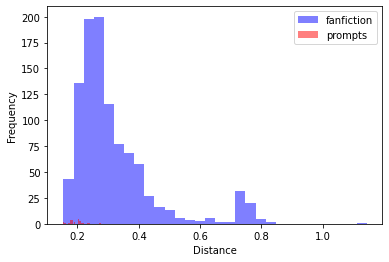

In [45]:
plot_differences(nonpromptsdis, promptsdis)

In [136]:
def plot_differences_with_threshold(df_fanfiction, df_prompts, field="Distance", threshold=None 
                                    ,save_format ="jpg" , filename="plot.jpg" , out_path = "/Images" ):
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Create a histogram of the "distance" column in df_fanfiction, colored blue
    ax.hist(df_fanfiction[field], bins=30, alpha=0.5, color="blue", label="fanfiction")

    # Create a histogram of the "distance" column in df_prompts, colored red
    ax.hist(df_prompts[field], bins=30, alpha=0.5, color="red", label="prompts")

    # Set the x and y axis labels
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

    # Add a legend
    ax.legend()

    # Add a vertical line at the threshold value, if provided
    if threshold is not None:
        ax.axvline(x=threshold, color='black', linestyle='--')
        ax.text(threshold, ax.get_ylim()[1]*1.05, f'Threshold: {threshold:.2f}', ha='center', va='top', fontsize=12)
    fig.set_facecolor('white')
    fig.savefig(os.path.join(out_path, filename), format=save_format , dpi=300)
    # Show the plot
#     plt.style.use('classic')
    plt.show()
    

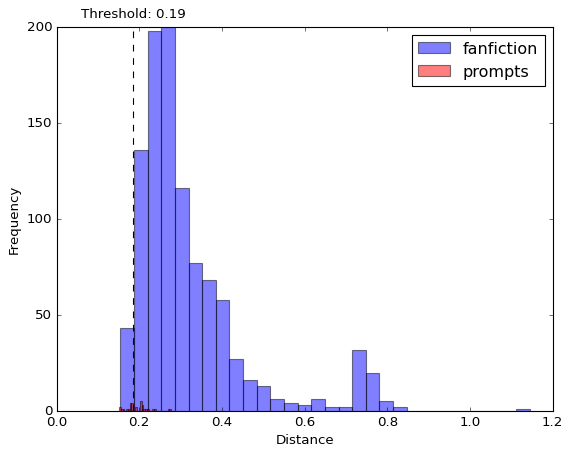

In [137]:
plot_differences_with_threshold(nonpromptsdis, promptsdis, threshold=best_threshold,
                                filename=key_word+"-both_histogram.jpg" , out_path = experimentpath+"/Images")

In [138]:
def plot1(df , field = "Distance" , color = "blue" , label = "fanfiction" , threshold=None
         ,save_format ="jpg" , filename="plot.jpg" , out_path = "/Images" ):
    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Create a histogram of the "distance" column in df_fanfiction, colored blue
    ax.hist(df[field], bins=30, alpha=0.5, color=color, label=label , range=[0, 1.5])
        # Set the x and y axis labels
    ax.set_xlabel("Distance")
    ax.set_ylabel("Frequency")

    # Add a legend
    ax.legend()
    if threshold is not None:
        ax.axvline(x=threshold, color='black', linestyle='--')
        ax.text(threshold, ax.get_ylim()[1]*1.05, f'Threshold: {threshold:.2f}', ha='center', va='top', fontsize=12)
    fig.set_facecolor('white')
    fig.savefig(os.path.join(out_path, filename), format=save_format , dpi=300)
    # Show the plot
    plt.show()

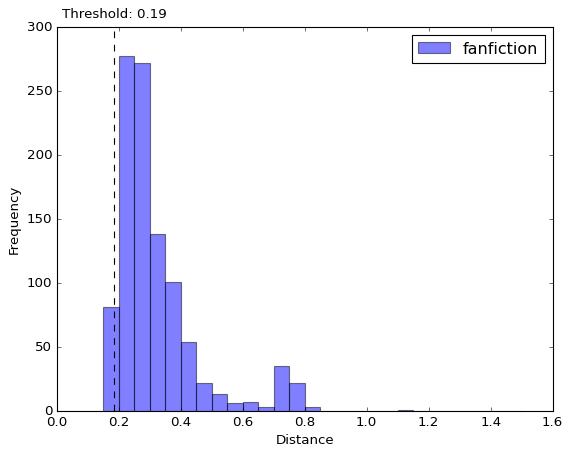

In [139]:
plot1(nonpromptsdis, threshold=best_threshold ,
      filename=key_word+"-fanfiction_histogram.jpg" , out_path = experimentpath+"/Images")

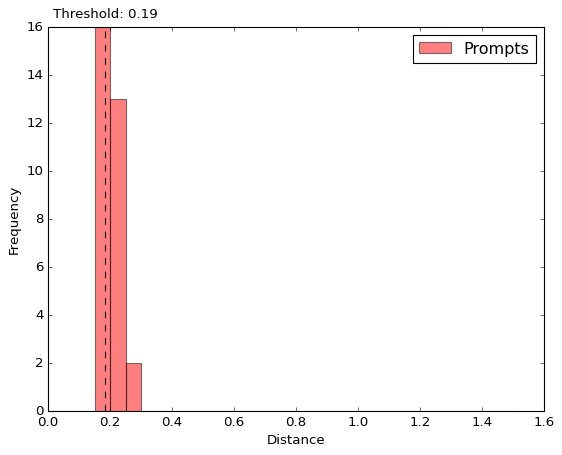

In [140]:
plot1(promptsdis ,color = "red" , label = "Prompts" , threshold=best_threshold,
                             filename=key_word+"-prompts_histogram.jpg" , out_path = experimentpath+"/Images")

## Histogram of Writers

In [112]:
def makebigdf(folder_path ):
    # List of all CSV files in the folder
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

    # Initialize an empty list to store dataframes
    dfs = []

    # Iterate over each CSV file and read it into a dataframe
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dfs.append(df)

    # Concatenate all dataframes into one big dataframe
    big_df = pd.concat(dfs, ignore_index=True)
    return big_df

In [113]:
bigDF = makebigdf(experimentpath+"/Data/2Stories_OrLess_Undivided")

In [114]:
def entries_hist(df , field , title):
    device_counts = df[field].value_counts()

    # Create a bar chart of the device counts
    device_counts.plot(kind="hist")

    # Add labels to the plot
    plt.xlabel("Fan Fiction written")
    plt.ylabel("Number of Fanfiction Writters")
    plt.title(title)

    # Display the plot
    plt.show()

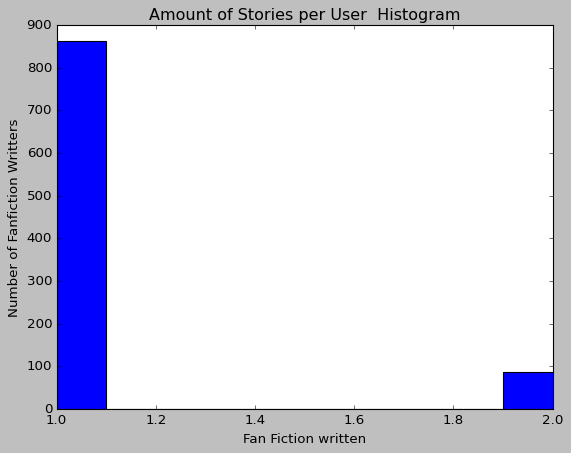

In [115]:
entries_hist(bigDF, "Author URL", "Amount of Stories per User  Histogram")

In [116]:
type(bigDF)

pandas.core.frame.DataFrame

In [117]:
evice_counts = bigDF["Author URL"].value_counts()
evice_counts

https://www.fanfiction.net/u/2373033/Ebaz                       2
https://www.fanfiction.net/u/5304029/totheart                   2
https://www.fanfiction.net/u/4490592/IgorThemii                 2
https://www.fanfiction.net/u/5419210/incxndium                  2
https://www.fanfiction.net/u/4460514/TheBitterSnow              2
                                                               ..
https://www.fanfiction.net/u/5760581/hemlockSindri              1
https://www.fanfiction.net/u/3069625/HeroxPartnerfan96          1
https://www.fanfiction.net/u/6199863/Heruseus                   1
https://www.fanfiction.net/u/2544375/Hieisteel                  1
https://www.fanfiction.net/u/5880161/StevenAndNathan-Fan-Fic    1
Name: Author URL, Length: 949, dtype: int64

In [118]:
evice_counts.head(20)

https://www.fanfiction.net/u/2373033/Ebaz                   2
https://www.fanfiction.net/u/5304029/totheart               2
https://www.fanfiction.net/u/4490592/IgorThemii             2
https://www.fanfiction.net/u/5419210/incxndium              2
https://www.fanfiction.net/u/4460514/TheBitterSnow          2
https://www.fanfiction.net/u/2539158/TheKeyToDestiny        2
https://www.fanfiction.net/u/5675019/pikaree1               2
https://www.fanfiction.net/u/1666528/pikachufanno9          2
https://www.fanfiction.net/u/2706778/PettyFan43             2
https://www.fanfiction.net/u/5041628/Empty-Corpse           2
https://www.fanfiction.net/u/5551838/Brittannia-Angel       2
https://www.fanfiction.net/u/4832096/Time-Signature         2
https://www.fanfiction.net/u/5925303/PearlxAdvance          2
https://www.fanfiction.net/u/6385448/Peanut-the-Elephant    2
https://www.fanfiction.net/u/4768935/Topazique              2
https://www.fanfiction.net/u/5590327/blazic                 2
https://

In [119]:
evice_counts.sum()

1035

In [120]:
len(evice_counts)

949

## Write Summary

In [157]:
create_readme(key_word, experimentpath)

In [158]:

part1 =  f"""## Goal of the Experiment
In this experiment we try to see if we can detect chatGPT written text on a topic using LPA.

We have taken {evice_counts.sum()} stories written by {len(evice_counts)} different writers on {key_word}.

We also took {len(prompts)} chatGPT written story on that same topic in order to compare the distances from the DVR in order to find the difference and the threshold between the human written text and the chatGPT written text.

## Pre-Processing the Data
The {key_word} Fan Fiction was taken and cleaned from archive.org at [fan fiction dump](https://archive.org/download/Fanfictiondotnet1011dump)
- After downloading the raw data to the Dataset folder we unzip only the files with {key_word} in their name to Data/FanFictionTXT folder.
- Since all thet files are in txt form and contain metadata we create from each text file a csv with all the data separated in Data/FanFictionCSV
- We also create a prompts csv folder which contains each story and the prompt that created it in a unique csv file in Data/Prompts.
- We calculate the minimum and maximum of words in each ChatGPT story in order to use only stories with similar sizes (between {min_length} and {max_length} words per story here)
- We move only the stories with the appropriate sizes (+-50 words from the minimum and maximum) in Data/FanFictionNormalSizesCSV
- We Divide All of the stories by authors each author gets a floder with his own folder in Data/Divided_by_authors
- We Create a new folder with only the authors who have 2 stories or less in Data/authors_with_2Stories_OrLess
- We take all the stories from authors_with_2Stories_OrLess and copy all of them into a new folder 2Stories_OrLess_Undivided which the DVR will be created from
- We do a word frequency to the prompts authors_with_2Stories_OrLess and 2Stories_OrLess_Undivided each at a folder named word_freq in the respective folders

## Running LPA
After we have all the Data ready we are ready to run LPA and calculate distances
- We run DVR on all the Human made FanFiction which is named {key_word}-dvr.csv this iis the vector we compare all the distances to.
- We calculate and save the prompts DVR in Results/Prompts folder
- We calculate the signatures of each story to the Signatures divided in 3 folders , prompts , authors and undivided by authors
- We calculate the dvr of each author to Results\Author_Results
- We calculate the Distances into Results/Distances folder
- We have distnces of prompts from human-dvr, distnces of human from human-dvr and distnces of prompts from prompts-dvr

## Results

### Distances
The average distance of the real fanfiction from the DVR is: {nonpromptsdis["Distance"].mean():.2f}
The average distance of the poromts fanfiction from the DVR is: {promptsdis["Distance"].mean():.2f}
After running a t-test we we arrived at this conclusion at 95% certainty:
{test_dataset_difference(nonpromptsdis, promptsdis)}

The best range that found is {best_threshold:.2f} which means that {message}
Our best f1 result was {best_f1:.2f} 

#### Results histograms
The histograms images can be found at Images folders

![](../{experimentpath.rsplit("/", 1)[-1]+"/Images/"+ key_word+"-fanfiction_histogram.jpg"})

![](../{experimentpath.rsplit("/", 1)[-1]+"/Images/"+ key_word+"-prompts_histogram.jpg"})

![](../{experimentpath.rsplit("/", 1)[-1]+"/Images/"+ key_word+"-both_histogram.jpg"})
"""

In [159]:
append_to_readme(part1, experimentpath+'/README.md')